# Prime Editing (PE) Coverage Analysis

- This notebook provides a quantification of the capabilities of prime editing to model mutations present in the MSK IMPACT dataset.
- Assumptions:
    - Using an NG PAM site for the base editor
    - Haven't thoroughly analyzed potential off-target effects of a given pegRNA
        - Focusing on simply ability to target a mutationw with a pegRNA

For more information regarding MSK IMPACT dataset collection methods, etc., see: 
- https://www.mskcc.org/msk-impact
- https://datacatalog.mskcc.org/dataset/10438

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv

/Users/samgould/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
filepath = '/Volumes/Sam_G_SSD/2020-06-16-MSK-IMPACT_EDITED.txt'
impact_data = pd.read_csv(filepath, sep='\t')

/Users/samgould/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: DtypeWarning: Columns (45,48,88) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
impact_data

,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Consequence,Variant_Classification,...,VARIANT_CLASS,all_effects,amino_acid_change,cDNA_Change,cDNA_position,cdna_change,comments,n_depth,t_depth,transcript
0,BRCA2,675,MSKCC,GRCh37,13,32937315,32937315,+,splice_acceptor_variant,Splice_Site,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BRCA2,0,MSKCC,37,13,32914437,32914438,+,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MUTYH,4595,MSKCC,GRCh37,1,45798475,45798475,+,missense_variant,Missense_Mutation,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BRCA2,675,MSKCC,GRCh37,13,32893302,32893302,+,frameshift_variant,Frame_Shift_Ins,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BRCA1,0,MSKCC,37,17,41251824,41251825,+,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422817,SMARCA4,6597,MSKCC,GRCh37,19,11144132,11144132,+,missense_variant,Missense_Mutation,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
422818,BRAF,673,MSKCC,GRCh37,7,140453149,140453149,+,missense_variant,Missense_Mutation,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
422819,NRAS,4893,MSKCC,GRCh37,1,115258747,115258747,+,missense_variant,Missense_Mutation,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
422820,TERT,7015,MSKCC,GRCh37,5,1295521,1295521,+,upstream_gene_variant,5'Flank,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#list of unique genes tested
unique_genes = np.unique(np.asarray(impact_data['Hugo_Symbol']))
print('There are ' + str(len(unique_genes)) + ' unique genes observed')

There are 594 unique genes observed


# Loading in reference human genome for epegRNA design

- can check for PAM sequences on either side of the mutation (+/- strand?)
- Downloading reference sequence from: https://www.ncbi.nlm.nih.gov/assembly/GCF_000001405.26/ (assembly GRCh38)
- GRCh37: https://www.ncbi.nlm.nih.gov/assembly/GCF_000001405.25


In [8]:
from Bio import SeqIO
import gzip

In [9]:
#MSK IMPACT dataset uses GrCh37 build
np.unique(np.asarray(impact_data['NCBI_Build']))

array(['37', 'GRCh37'], dtype=object)

In [10]:
file = '/Volumes/Sam_G_SSD/GRCh37/ncbi-genomes-2022-03-17/GCF_000001405.25_GRCh37.p13_genomic.fna.gz'

with gzip.open(file, "rt") as handle:
    records = list(SeqIO.parse(handle, "fasta")) #about 4 Gb in  memory
    #records = list that contains sequences split up by chromosome (and intrachromosome splits up to some size)

In [11]:
#filtering out alternative sequences to only select consensus matches


wrong = ["alternate", "unplaced", "unlocalized", "patch"]
badlist = []
for key in wrong:
    for i in records:
        ii = i.description
        if key in ii:
            badlist.append(ii)
            
filtered = []
index_list = []
for idx, i in enumerate(records):
    ii = i.description
    if ii not in badlist:
        filtered.append(ii)
        index_list.append(idx)
        
filtered
    

['NC_000001.10 Homo sapiens chromosome 1, GRCh37.p13 Primary Assembly',
 'NC_000002.11 Homo sapiens chromosome 2, GRCh37.p13 Primary Assembly',
 'NC_000003.11 Homo sapiens chromosome 3, GRCh37.p13 Primary Assembly',
 'NC_000004.11 Homo sapiens chromosome 4, GRCh37.p13 Primary Assembly',
 'NC_000005.9 Homo sapiens chromosome 5, GRCh37.p13 Primary Assembly',
 'NC_000006.11 Homo sapiens chromosome 6, GRCh37.p13 Primary Assembly',
 'NC_000007.13 Homo sapiens chromosome 7, GRCh37.p13 Primary Assembly',
 'NC_000008.10 Homo sapiens chromosome 8, GRCh37.p13 Primary Assembly',
 'NC_000009.11 Homo sapiens chromosome 9, GRCh37.p13 Primary Assembly',
 'NC_000010.10 Homo sapiens chromosome 10, GRCh37.p13 Primary Assembly',
 'NC_000011.9 Homo sapiens chromosome 11, GRCh37.p13 Primary Assembly',
 'NC_000012.11 Homo sapiens chromosome 12, GRCh37.p13 Primary Assembly',
 'NC_000013.10 Homo sapiens chromosome 13, GRCh37.p13 Primary Assembly',
 'NC_000014.8 Homo sapiens chromosome 14, GRCh37.p13 Primary A

In [11]:
chromosome = 20
#22 (23-1) = X
#23 (24-1) = Y
#24 (25-1) = mitochondrial DNA
records[index_list[chromosome-1]]

SeqRecord(seq=Seq('NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...NNN', SingleLetterAlphabet()), id='NC_000020.10', name='NC_000020.10', description='NC_000020.10 Homo sapiens chromosome 20, GRCh37.p13 Primary Assembly', dbxrefs=[])

In [13]:
k=902
print('ref = ' + impact_data.iloc[[k]]['Reference_Allele'].values[0])
#print('al1 = ' + impact_data.iloc[[k]]['Tumor_Seq_Allele1'].values[0])
#print('al2 = ' + impact_data.iloc[[k]]['Tumor_Seq_Allele2'].values[0])
seq_start = impact_data.iloc[[k]]['Start_Position'].values[0]
seq_end = impact_data.iloc[[k]]['End_Position'].values[0]
chromosome = impact_data.iloc[[k]]['Chromosome'].values[0]
seq1 = records[index_list[int(chromosome)-1]].seq
seq1[seq_start-1: seq_end]

ref = TCATCG


Seq('TCATCG', SingleLetterAlphabet())

Sequence start is offset by 1 (i.e. need to subtract 1 from start position to get true sequence information). 

# Loading in gene coordinate information

In [7]:
filename1 = '/Users/samgould/Desktop/FSR Lab/2022-03-17/gene_info.csv'
df1 = pd.read_csv(filename1)
df1

,gene,gene_id,transcript_id,chrom,gene_start,gene_end,transcript_start,transcript_end,strand
0,ABL1,ENSG00000097007.13,ENST00000318560.5,chr9,133589333,133763062,133710453,133763062,+
1,AC004906.3,ENSG00000237286.1,ENST00000423194.1,chr7,2983669,2986725,2983669,2986725,+
2,AC008738.1,ENSG00000230259.2,ENST00000425420.2,chr19,33790853,33793430,33790853,33793430,-
3,ACTG1,ENSG00000184009.5,ENST00000575842.1,chr17,79476997,79490873,79477015,79479807,-
4,ACVR1,ENSG00000115170.9,ENST00000263640.3,chr2,158592958,158732374,158592958,158731623,-
...,...,...,...,...,...,...,...,...,...
589,XRCC2,ENSG00000196584.2,ENST00000359321.1,chr7,152341864,152373250,152343589,152373250,-
590,YAP1,ENSG00000137693.9,ENST00000282441.5,chr11,101981192,102104154,101981192,102104154,+
591,YES1,ENSG00000176105.9,ENST00000314574.4,chr18,721588,812547,721748,812239,-
592,ZFHX3,ENSG00000140836.10,ENST00000268489.5,chr16,72816784,73093597,72816784,73082274,-


# Prime Editing Coverage Quantification


## Assumptions
- For insertions and deletions, also need to take into account the size of the indel...
- using an NG PAM sequence
- when looking at the size of the RT template, not taking into account the need for homology at the end of the template...
    - this can be accounted for easily by reducing the size of the RT template.

In [242]:
import re

def prime_domains(gene_name, rt_template_length, df1):
    "Returns vector containing pegRNA coverage for a given gene (+/- 200 bp of start/end)"
    
    #df1 is the dataframe containing gene sequence information

    gene_chrom = df1[df1['gene']==gene_name]['chrom'].values[0]
    
    if gene_chrom != 'chrX':
        chrom = int(re.search(r'\d+', gene_chrom).group())
    elif gene_chrom=='chrX':
        chrom = 23 #it's number 22, but we subtract 1 below when accessing chromosome file
        #there are no genes in this dataset that fall on Y chromosome -- ignoring

    seq_start = df1[df1['gene']==gene_name]['gene_start'].values[0]
    seq_end = df1[df1['gene']==gene_name]['gene_end'].values[0]

    gene_sequence_200eitherend = records[index_list[int(chrom)-1]].seq[seq_start-201: seq_end+200]
    #gene sequence with 200 bp buffer on either end to account for prime domains at beginning of gene

    length_seq = len(gene_sequence_200eitherend)

    zero_array = np.zeros(length_seq)

    #iterate through sequence

    #iterate +- 150 bp from start/end of gene
    for idx, val in enumerate(gene_sequence_200eitherend[50:length_seq-50]): 
        
        if val == 'g': #find NGs
            zero_array[idx-4:idx+rt_template_length-4] += 1#add array of ones at appropriate index when NG is encountered

            #THIS ISN't EXACTLY RIGHT FOR EITHER END OF THE GENE!!!!!

        elif val == 'G':
            zero_array[idx-4:idx+rt_template_length-4] += 1

        else:
            continue


    #repeat on negative strand
    comp = gene_sequence_200eitherend.complement() #taking complement (- strand in same orientation)
    for idx, val in enumerate(comp):
        if val == 'g':
            zero_array[idx+4-rt_template_length:idx+4] += 1
        elif val == 'G':
            zero_array[idx+4-rt_template_length:idx+4] += 1
        else:
            continue
    
    
    return zero_array[200:length_seq-200] #cut off the 200 bp bumper placed on either end of gene
    
    

In [245]:
#Testing with an example gene to test coverage

filename1 = '/Users/samgould/Desktop/FSR Lab/2022-03-17/gene_info.csv'
df1 = pd.read_csv(filename1)

gene_name = 'TP53'
rt_template_length = 7

kkk = prime_domains(gene_name, rt_template_length, df1)

unique, counts = np.unique(kkk, return_counts=True)


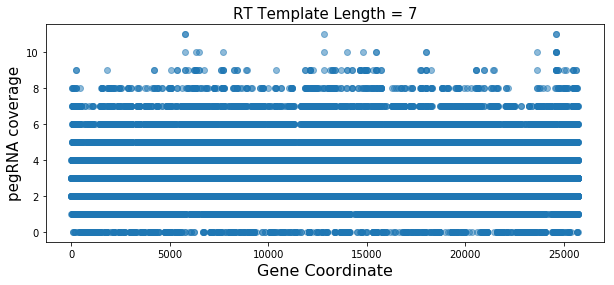

In [247]:
plt.figure(figsize=(10,4))

plt.scatter(range(len(kkk[0:])),kkk[0:], alpha=0.5)
plt.xlabel('Gene Coordinate', fontsize=16)
plt.ylabel('pegRNA coverage', fontsize=15)
plt.title('RT Template Length = ' + str(rt_template_length), fontsize=15);

## Now performing this analysis to get coverage for all genes in the dataset...

In [248]:
#list of unique genes tested
unique_genes = np.unique(np.asarray(impact_data['Hugo_Symbol']))
print('There are ' + str(len(unique_genes)) + ' unique genes observed')

There are 594 unique genes observed


In [256]:
rt_template_length = np.linspace(1,50,50)
rt_template_length

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.])

In [259]:
filename1 = '/Users/samgould/Desktop/FSR Lab/2022-03-17/gene_info.csv'
df1 = pd.read_csv(filename1)

rt_template_length = np.linspace(1,50,50) #iterating through all RT template lengths from 1 to 50

for x in rt_template_length:
    
    rt_template_length = int(x)
    rt_len = [] #coverage array for holding information

    for gene in unique_genes:

        gene_name = gene

        kkk = prime_domains(gene_name, rt_template_length, df1)

        unique, counts = np.unique(kkk, return_counts=True)

        rt_len.append(kkk)
        
    filepath = '/Volumes/Sam_G_SSD/PE coverage npy arrays/'
    np.save(filepath + 'PE_coverage_rt' + str(rt_template_length) +'.npy', np.asarray(rt_len))
    print('complete rt template length = ' + str(rt_template_length))


complete rt template length = 1
complete rt template length = 2
complete rt template length = 3
complete rt template length = 4
complete rt template length = 5
complete rt template length = 6
complete rt template length = 7
complete rt template length = 8
complete rt template length = 9
complete rt template length = 10
complete rt template length = 11
complete rt template length = 12
complete rt template length = 13
complete rt template length = 14
complete rt template length = 15
complete rt template length = 16
complete rt template length = 17
complete rt template length = 18
complete rt template length = 19
complete rt template length = 20
complete rt template length = 21
complete rt template length = 22
complete rt template length = 23
complete rt template length = 24
complete rt template length = 25
complete rt template length = 26
complete rt template length = 27
complete rt template length = 28
complete rt template length = 29
complete rt template length = 30
complete rt templat

In [266]:
filepath = '/Volumes/Sam_G_SSD/PE coverage npy arrays/'
rt50 = np.load(filepath + 'PE_coverage_rt50.npy')

## Prime editing boundaries
Performing similar analysis, but this time getting coordinates of prime editing domains.

Splitting it up into two arrays, corresponding to (+) strand and (-) strand. This directionality information is required for further analysis. 

The only information needed is the starting location of the editing domain (as well as which strand it's occuring on), which will be marked with a 1 in the array of zeros. From there, with knowledge of the RT template size and the other prime editing domain array, you can check whether a target mutation (applies to insertions and ONPs) falls within the boundary of a single prime editing domain, or crosses multiple domains (in this case the edit isn't possible with the given RT template length). 


In [149]:
import re

def prime_domains_boundaries(gene_name, rt_template_length, df1):
    #df1 is the dataframe containing gene sequence information

    gene_chrom = df1[df1['gene']==gene_name]['chrom'].values[0]
    
    if gene_chrom != 'chrX':
        chrom = int(re.search(r'\d+', gene_chrom).group())
    elif gene_chrom=='chrX':
        chrom = 23 #it's number 22, but we subtract 1 below when accessing chromosome file
        #there are no genes in this dataset that fall on Y chromosome -- ignoring

    seq_start = df1[df1['gene']==gene_name]['gene_start'].values[0]
    seq_end = df1[df1['gene']==gene_name]['gene_end'].values[0]

    gene_sequence_200eitherend = records[index_list[int(chrom)-1]].seq[seq_start-201: seq_end+200]
    #gene sequence with 200 bp buffer on either end to account for prime domains at beginning of gene

    length_seq = len(gene_sequence_200eitherend)

    #two arrays corresponding to plus and minus end
    zero_array_plus = np.zeros(length_seq)
    zero_array_minus = np.zeros(length_seq)

    #iterate through sequence

    #iterate +- 150 bp from start/end of gene
    for idx, val in enumerate(gene_sequence_200eitherend[50:length_seq-50]): 
        
        if val == 'g': #find NGs
            zero_array_plus[idx-4] += 1#add array of ones at appropriate index when NG is encountered

            #THIS ISN't EXACTLY RIGHT FOR EITHER END OF THE GENE!!!!!

        elif val == 'G':
            zero_array_plus[idx-4] += 1

        else:
            continue


    #repeat on negative strand
    comp = gene_sequence_200eitherend.complement() #taking complement (- strand in same orientation)
    for idx, val in enumerate(comp):
        
        if idx+4 < length_seq: #weird boundary issue
        
            if val == 'g':
                zero_array_minus[idx+4] += 1
            elif val == 'G':
                zero_array_minus[idx+4] += 1
            else:
                continue
        
        else:
            continue
    
    zero_array_plus1 = zero_array_plus[200:length_seq-200]
    zero_array_minus1 = zero_array_minus[200:length_seq-200]
    
    
    return [zero_array_plus1,zero_array_minus1] #cut off the 200 bp bumper placed on either end of gene
    

In [150]:
gene_name = 'TP53'
rt_template_length=7
plus_minus = prime_domains_boundaries(gene_name, rt_template_length, df1)

In [160]:
#repeating same process as above
filename1 = '/Users/samgould/Desktop/FSR Lab/2022-03-17/gene_info.csv'
df1 = pd.read_csv(filename1)

rt_template_length = np.linspace(2,50,49) #iterating through all RT template lengths from 1 to 50

for x in rt_template_length:
    
    rt_template_length = int(x)
    rt_len = [] #coverage array for holding information

    for gene in unique_genes:

        gene_name = gene

        kkk = prime_domains_boundaries(gene_name, rt_template_length, df1)

        unique, counts = np.unique(kkk, return_counts=True)

        rt_len.append(kkk)
        
    filepath = '/Volumes/Sam_G_SSD/PE coverage boundary arrays/'
    np.save(filepath + 'PE_coverage_boundary_rt' + str(rt_template_length) +'.npy', np.asarray(rt_len))
    print('complete rt template length = ' + str(rt_template_length))
        #print(gene + ': ' + str(np.round((100*(len(kkk) - counts[0])/len(kkk)),3)) + '% PE coverage')

complete rt template length = 2
complete rt template length = 3
complete rt template length = 4
complete rt template length = 5
complete rt template length = 6
complete rt template length = 7
complete rt template length = 8
complete rt template length = 9
complete rt template length = 10
complete rt template length = 11
complete rt template length = 12
complete rt template length = 13
complete rt template length = 14
complete rt template length = 15
complete rt template length = 16
complete rt template length = 17
complete rt template length = 18
complete rt template length = 19
complete rt template length = 20
complete rt template length = 21
complete rt template length = 22
complete rt template length = 23
complete rt template length = 24
complete rt template length = 25
complete rt template length = 26
complete rt template length = 27
complete rt template length = 28
complete rt template length = 29
complete rt template length = 30
complete rt template length = 31
complete rt templa

# Next step = quantifying whether mutations in IMPACT data set fall within editing windows at varying RT template lengths

variant_type keys: 
- SNP: Single nucleotide polymorphism -- a substitution in one nucleotide
- DNP: Double nucleotide polymorphism -- a substitution in two consecutive nucleotides
- TNP: Triple nucleotide polymorphism -- a substitution in three consecutive nucleotides
- ONP: Oligo-nucleotide polymorphism -- a substitution in more than three consecutive nucleotides
- INS: Insertion -- the addition of nucleotides
- DEL: Deletion -- the removal of nucleotides


In [29]:
mut_types= impact_data['Variant_Type'].value_counts()
mut_types

SNP    348145
DEL     49838
INS     17784
DNP      6042
ONP      1011
TNP         1
UNK         1
Name: Variant_Type, dtype: int64

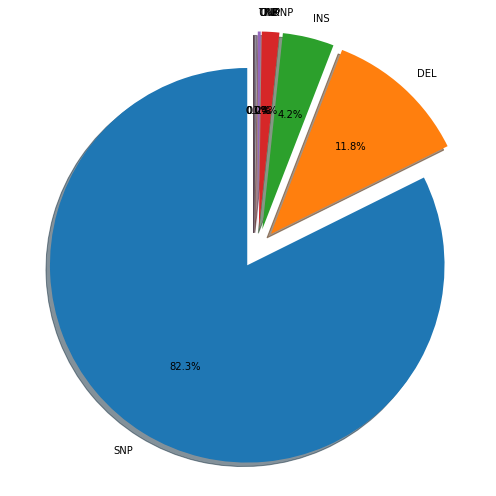

<Figure size 432x288 with 0 Axes>

In [251]:
labels = np.asarray(impact_data['Variant_Type'].unique())
sizes = mut_types
explode = (0.1, 0.1, 0.1, 0.1,0.1,0.1,0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()
#plt.savefig('Pie_mutation_rep.png', dpi=200)

## assumptions

- Assuming that RT template length is not limiting for engineering deletions
- However, RT length must be ≥ size of insertion in order for it to work
    - This doesn't account for the need for homology arms. RT template length can be thought of here as the template length with edits included, but excluding the extra basepairs needed for homology...
    - I'm IGNORING the necessity for a region of homology in the RT template. This simplifies the analysis, and any homology requirements can be very simply added to the this analysis without changing the code (e.g. if 10 bp of homology required, and edit can be captured with RT template length of 7 as calculated here, then total RT template length size = 17).

In [178]:
def coverage_classifier(impact_data, df1, rt_template_length):
    #load in (1) impact_data, 
    #(2) df containing gene coordinate info
    #(3) length of rt template
    
    filepath_boundary = '/Volumes/Sam_G_SSD/PE coverage boundary arrays/' + 'PE_coverage_boundary_rt' + str(rt_template_length) +'.npy'
    filepath_coverage = '/Volumes/Sam_G_SSD/PE coverage npy arrays/' + 'PE_coverage_rt' + str(rt_template_length) +'.npy'
  
    PE_domain_coverage = np.load(filepath_coverage)
    PE_domain_boundary = np.load(filepath_boundary)#for plus and minus strand
    
    unique_genes = list(np.unique(np.asarray(impact_data['Hugo_Symbol'])))
    
    #iterate through mutations in IMPACT dataset
    num_mutations = len(impact_data)
    
    #initialize array of zeros for holding information about coverage
    zeros = np.zeros(num_mutations)
    
    #initialize array for holding weird cases with bad location
    outside_domain = []
    
    for i in range(num_mutations):

        #get info on current mut
        mut = impact_data.iloc[i]
        
        #getting type of mutations
        mut_type = mut['Variant_Type'] 
        
        #getting gene and start/end position of mutation
        gene = mut['Hugo_Symbol']
        gene_index = unique_genes.index(gene) #retrieving index
        
        seq_start = df1[df1['gene']==gene]['gene_start'].values[0] 
        
        s = mut['Start_Position']
        e = mut['End_Position']
        size_mut = (e-s)+1 #size of mutation
        
        #re-indexing with start of gene as position 0
        start_true = s-seq_start
        end_true = e-seq_start+1
    
        #retrieving the appropriate gene's prime editing domain
        PE_domain = PE_domain_coverage[gene_index]
        PE_domain_bound = PE_domain_boundary[gene_index]
    
        #first checking for weird boundary misc.
        if (start_true or end_true)>len(PE_domain):
            outside_domain.append(i)
            
        else:

            if mut_type == 'SNP':
                val = PE_domain[start_true]

                if val >0:
                    zeros[i] +=1
                else:
                    continue

            elif mut_type =='DEL':
                #only need to check that the start is in PE domain (not accounting for homology arms)
                val = PE_domain[start_true]

                if val >0:
                    zeros[i] +=1
                else:
                    continue

            elif mut_type == 'INS':
                #first check rt template length is at least size of insertion
                if rt_template_length >= size_mut:
                    pe_cover = PE_domain[start_true:end_true]

                    if all(kk>0 for kk in pe_cover):#then check coverage)

                        plus_end = PE_domain_bound[0] 
                        minus_end = PE_domain_bound[1]
                        #finally check boundary condition
                        diff_sizes = rt_template_length-size_mut

                        bounds_plus = plus_end[start_true-diff_sizes:start_true+1] 
                        bounds_minus = minus_end[end_true:(end_true+diff_sizes+1)]

                        #if start site is anywhere within these bounds, boundary condition satisfied
                        sum_bound = np.sum(bounds_plus)+np.sum(bounds_minus)

                        if sum_bound>=1:

                            zeros[i] +=1
                        else:
                            continue

                    else:
                        continue

                else:
                    continue


            elif mut_type == 'DNP':
                if rt_template_length >= 2:
                    pe_cover = PE_domain[start_true:end_true]

                    if all(kk>0 for kk in pe_cover):#then check coverage)

                        plus_end = PE_domain_bound[0] 
                        minus_end = PE_domain_bound[1]
                        #finally check boundary condition
                        diff_sizes = rt_template_length-size_mut

                        bounds_plus = plus_end[start_true-diff_sizes:start_true+1] 
                        bounds_minus = minus_end[end_true:(end_true+diff_sizes+1)]

                        #if start site is anywhere within these bounds, boundary condition satisfied
                        sum_bound = np.sum(bounds_plus)+np.sum(bounds_minus)

                        if sum_bound>=1:

                            zeros[i] +=1
                        else:
                            continue

                    else:
                        continue

                else:
                    continue


            elif mut_type == 'ONP':
                if rt_template_length >= size_mut:
                    pe_cover = PE_domain[start_true:end_true]

                    if all(kk>0 for kk in pe_cover):#then check coverage)

                        plus_end = PE_domain_bound[0] 
                        minus_end = PE_domain_bound[1]
                        #finally check boundary condition
                        diff_sizes = rt_template_length-size_mut

                        bounds_plus = plus_end[start_true-diff_sizes:start_true+1] 
                        bounds_minus = minus_end[end_true:(end_true+diff_sizes+1)]

                        #if start site is anywhere within these bounds, boundary condition satisfied
                        sum_bound = np.sum(bounds_plus)+np.sum(bounds_minus)

                        if sum_bound>=1:

                            zeros[i] +=1
                        else:
                            continue

                    else:
                        continue

                else:
                    continue


            elif mut_type == 'TNP':
                if rt_template_length >= 3:
                    pe_cover = PE_domain[start_true:end_true]

                    if all(kk>0 for kk in pe_cover):#then check coverage)

                        plus_end = PE_domain_bound[0] 
                        minus_end = PE_domain_bound[1]
                        #finally check boundary condition
                        diff_sizes = rt_template_length-size_mut

                        bounds_plus = plus_end[start_true-diff_sizes:start_true+1] 
                        bounds_minus = minus_end[end_true:(end_true+diff_sizes+1)]

                        #if start site is anywhere within these bounds, boundary condition satisfied
                        sum_bound = np.sum(bounds_plus)+np.sum(bounds_minus)

                        if sum_bound>=1:

                            zeros[i] +=1
                        else:
                            continue

                    else:
                        continue

                else:
                    continue


            elif mut_type == 'UNK':
                #IGNORING UNCLASSIFIED MUTANTS
                continue

    return zeros, outside_domain

In [185]:
rt_template_length = np.linspace(1,50,50) #iterating through all RT template lengths from 1 to 50

for x in rt_template_length:
    
    rt_template_length = int(x)
       
    coverage, outside_domain = coverage_classifier(impact_data, df1, rt_template_length)
    
    filepath = '/Volumes/Sam_G_SSD/PE coverage quant/'
    np.save(filepath + 'MSK_PE_coverage_rt' + str(rt_template_length) +'.npy', np.asarray(coverage))
    np.save(filepath + 'outsidedomain_rt' + str(rt_template_length) +'.npy', np.asarray(outside_domain))
    print('complete rt template length = ' + str(rt_template_length))


complete rt template length = 1
complete rt template length = 2
complete rt template length = 3
complete rt template length = 4
complete rt template length = 5
complete rt template length = 6
complete rt template length = 7
complete rt template length = 8
complete rt template length = 9
complete rt template length = 10
complete rt template length = 11
complete rt template length = 12
complete rt template length = 13
complete rt template length = 14
complete rt template length = 15
complete rt template length = 16
complete rt template length = 17
complete rt template length = 18
complete rt template length = 19
complete rt template length = 20
complete rt template length = 21
complete rt template length = 22
complete rt template length = 23
complete rt template length = 24
complete rt template length = 25
complete rt template length = 26
complete rt template length = 27
complete rt template length = 28
complete rt template length = 29
complete rt template length = 30
complete rt templat

## checking indices that fall in "outside domain" (i.e. outside of gene)

In [61]:
filepath = '/Volumes/Sam_G_SSD/PE coverage quant/'

    
rt_template_length = 15
outside_domain = np.load(filepath + 'outsidedomain_rt' + str(rt_template_length) +'.npy')

pp = []
for i in outside_domain:
    v1 = impact_data.iloc[i]['Variant_Type']
    pp.append(v1)

np.unique(np.asarray(pp), return_counts=True)

(array(['DEL', 'DNP', 'INS', 'ONP', 'SNP'], dtype='<U3'),
 array([  15,  160,   14,  306, 5104]))

In [62]:
#checking whether any of these mutations are recurrent
g = []
prot = []
dna = []
for i in outside_domain:
    p = impact_data.iloc[i]['HGVSp_Short']
    d = impact_data.iloc[i]['HGVSc']
    gg = impact_data.iloc[i]['Hugo_Symbol']
    
    g.append(gg)
    prot.append(p)
    dna.append(d)

In [63]:
np.unique(np.asarray(g), return_counts=True)

(array(['EGFR', 'TERT'], dtype='<U4'), array([   1, 5598]))

## ALL BUT 1 of the errors fall in the TERT gene
- There is one error in EGFR
- can probably go back and fix this fairly easily at some point
- very weird
    - another reference confirms these are the correct gene coordinates: http://grch37.ensembl.org/Homo_sapiens/Gene/Summary?g=ENSG00000164362;r=5:1253262-1295184
    
    
- It seems that many of the ONP mutations are in the TERT region, so it's probably worthwhile to go back and redo that one in particular.

# Fixing TERT issue and running analysis on tert promoter mutations...


Just need to extend an additional 400 bp beyond the end of the gene to capture the promoter mutations.

## PE Fix

In [93]:
import re

def prime_domainsTERT(gene_name, rt_template_length, df1):
    #df1 is the dataframe containing gene sequence information
    
    gene_name='TERT'
    
    gene_chrom = df1[df1['gene']==gene_name]['chrom'].values[0]
    
    if gene_chrom != 'chrX':
        chrom = int(re.search(r'\d+', gene_chrom).group())
    elif gene_chrom=='chrX':
        chrom = 23 #it's number 22, but we subtract 1 below when accessing chromosome file
        #there are no genes in this dataset that fall on Y chromosome -- ignoring

    seq_start = df1[df1['gene']==gene_name]['gene_start'].values[0]
    seq_end = df1[df1['gene']==gene_name]['gene_end'].values[0]

    gene_sequence_200eitherend = records[index_list[int(chrom)-1]].seq[seq_start-201: seq_end+600]
    #gene sequence with 200 bp buffer on either end to account for prime domains at beginning of gene

    length_seq = len(gene_sequence_200eitherend)

    zero_array = np.zeros(length_seq)

    #iterate through sequence

    #iterate +- 150 bp from start/end of gene
    for idx, val in enumerate(gene_sequence_200eitherend[50:length_seq-50]): 
        
        if val == 'g': #find NGs
            zero_array[idx-4:idx+rt_template_length-4] += 1#add array of ones at appropriate index when NG is encountered

            #THIS ISN't EXACTLY RIGHT FOR EITHER END OF THE GENE!!!!!

        elif val == 'G':
            zero_array[idx-4:idx+rt_template_length-4] += 1

        else:
            continue


    #repeat on negative strand
    comp = gene_sequence_200eitherend.complement() #taking complement (- strand in same orientation)
    for idx, val in enumerate(comp):
        if val == 'g':
            zero_array[idx+4-rt_template_length:idx+4] += 1
        elif val == 'G':
            zero_array[idx+4-rt_template_length:idx+4] += 1
        else:
            continue
    
    
    return zero_array[200:length_seq-200] #cut off the 200 bp bumper placed on either end of gene
    
    

In [94]:
import re

def prime_domains_boundariesTERT(gene_name, rt_template_length, df1):
    #df1 is the dataframe containing gene sequence information
    
    gene_name='TERT'
    
    gene_chrom = df1[df1['gene']==gene_name]['chrom'].values[0]
    
    if gene_chrom != 'chrX':
        chrom = int(re.search(r'\d+', gene_chrom).group())
    elif gene_chrom=='chrX':
        chrom = 23 #it's number 22, but we subtract 1 below when accessing chromosome file
        #there are no genes in this dataset that fall on Y chromosome -- ignoring

    seq_start = df1[df1['gene']==gene_name]['gene_start'].values[0]
    seq_end = df1[df1['gene']==gene_name]['gene_end'].values[0]

    gene_sequence_200eitherend = records[index_list[int(chrom)-1]].seq[seq_start-201: seq_end+600]
    #gene sequence with 200 bp buffer on either end to account for prime domains at beginning of gene

    length_seq = len(gene_sequence_200eitherend)

    #two arrays corresponding to plus and minus end
    zero_array_plus = np.zeros(length_seq)
    zero_array_minus = np.zeros(length_seq)

    #iterate through sequence

    #iterate +- 150 bp from start/end of gene
    for idx, val in enumerate(gene_sequence_200eitherend[50:length_seq-50]): 
        
        if val == 'g': #find NGs
            zero_array_plus[idx-4] += 1#add array of ones at appropriate index when NG is encountered

            #THIS ISN't EXACTLY RIGHT FOR EITHER END OF THE GENE!!!!!

        elif val == 'G':
            zero_array_plus[idx-4] += 1

        else:
            continue


    #repeat on negative strand
    comp = gene_sequence_200eitherend.complement() #taking complement (- strand in same orientation)
    for idx, val in enumerate(comp):
        
        if idx+4 < length_seq: #weird boundary issue
        
            if val == 'g':
                zero_array_minus[idx+4] += 1
            elif val == 'G':
                zero_array_minus[idx+4] += 1
            else:
                continue
        
        else:
            continue
    
    zero_array_plus1 = zero_array_plus[200:length_seq-200]
    zero_array_minus1 = zero_array_minus[200:length_seq-200]
    
    
    return [zero_array_plus1,zero_array_minus1] #cut off the 200 bp bumper placed on either end of gene
    

In [96]:
rt_template_length=1
gene_name='TERT'
zero_array = prime_domainsTERT(gene_name, rt_template_length, df1)
zero_array2d = prime_domains_boundariesTERT(gene_name, rt_template_length, df1)

In [102]:
#repeating same process as above
filename1 = '/Users/samgould/Desktop/FSR Lab/2022-03-17/gene_info.csv'
df1 = pd.read_csv(filename1)

rt_template_length = np.linspace(1,50,50) #iterating through all RT template lengths from 1 to 50

for x in rt_template_length:
    
    rt_template_length = int(x)

    gene_name='TERT'
    zero_array = prime_domainsTERT(gene_name, rt_template_length, df1)
    zero_array2d = prime_domains_boundariesTERT(gene_name, rt_template_length, df1)
        
    filepath = '/Volumes/Sam_G_SSD/PE coverage TERT/'
    np.save(filepath + 'PE_coverage_domain_TERT_rt' + str(rt_template_length) +'.npy', zero_array)

    np.save(filepath + 'PE_coverage_boundary_TERT_rt' + str(rt_template_length) +'.npy', np.asarray(zero_array2d))
    print('complete rt template length = ' + str(rt_template_length))
        #print(gene + ': ' + str(np.round((100*(len(kkk) - counts[0])/len(kkk)),3)) + '% PE coverage')

complete rt template length = 1
complete rt template length = 2
complete rt template length = 3
complete rt template length = 4
complete rt template length = 5
complete rt template length = 6
complete rt template length = 7
complete rt template length = 8
complete rt template length = 9
complete rt template length = 10
complete rt template length = 11
complete rt template length = 12
complete rt template length = 13
complete rt template length = 14
complete rt template length = 15
complete rt template length = 16
complete rt template length = 17
complete rt template length = 18
complete rt template length = 19
complete rt template length = 20
complete rt template length = 21
complete rt template length = 22
complete rt template length = 23
complete rt template length = 24
complete rt template length = 25
complete rt template length = 26
complete rt template length = 27
complete rt template length = 28
complete rt template length = 29
complete rt template length = 30
complete rt templat

In [105]:
tert_muts = impact_data[impact_data['Hugo_Symbol']=='TERT']
tert_muts = tert_muts.reset_index()
tert_muts

,index,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Consequence,...,VARIANT_CLASS,all_effects,amino_acid_change,cDNA_Change,cDNA_position,cdna_change,comments,n_depth,t_depth,transcript
0,89,TERT,7015,MSKCC,GRCh37,5,1295228,1295228,+,upstream_gene_variant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,98,TERT,7015,MSKCC,GRCh37,5,1295228,1295228,+,upstream_gene_variant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,99,TERT,7015,MSKCC,GRCh37,5,1295228,1295228,+,upstream_gene_variant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,108,TERT,7015,MSKCC,GRCh37,5,1295228,1295228,+,upstream_gene_variant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,254,TERT,7015,MSKCC,GRCh37,5,1295250,1295250,+,upstream_gene_variant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6598,422533,TERT,7015,MSKCC,GRCh37,5,1295228,1295228,+,upstream_gene_variant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6599,422538,TERT,7015,MSKCC,GRCh37,5,1295228,1295228,+,upstream_gene_variant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6600,422690,TERT,7015,MSKCC,GRCh37,5,1295228,1295228,+,upstream_gene_variant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6601,422719,TERT,7015,MSKCC,GRCh37,5,1295250,1295250,+,upstream_gene_variant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [109]:
def coverage_classifierTERT(tert_muts, df1, rt_template_length):
    #load in (1) impact_data, 
    #(2) df containing gene coordinate info
    #(3) length of rt template
    
  
    filepath_coverage = '/Volumes/Sam_G_SSD/PE coverage TERT/'+ 'PE_coverage_domain_TERT_rt' + str(rt_template_length) +'.npy'
    filepath_boundary ='/Volumes/Sam_G_SSD/PE coverage TERT/'+'PE_coverage_boundary_TERT_rt' + str(rt_template_length) +'.npy'
    
   
    PE_domain_coverage = np.load(filepath_coverage)
    PE_domain_boundary = np.load(filepath_boundary)#for plus and minus strand
    
    #unique_genes = list(np.unique(np.asarray(impact_data['Hugo_Symbol'])))
    
    #iterate through mutations in IMPACT dataset
    num_mutations = len(tert_muts)
    
    #initialize array of zeros for holding information about coverage
    zeros = np.zeros(num_mutations)
    
    #initialize array for holding weird cases with bad location
    outside_domain = []
    
    for i in range(num_mutations):

        #get info on current mut
        mut = tert_muts.iloc[i]
        
        #getting type of mutations
        mut_type = mut['Variant_Type'] 
        
        #getting gene and start/end position of mutation
        gene = 'TERT'
        
        seq_start = df1[df1['gene']==gene]['gene_start'].values[0] 
        
        s = mut['Start_Position']
        e = mut['End_Position']
        size_mut = (e-s)+1 #size of mutation
        
        #re-indexing with start of gene as position 0
        start_true = s-seq_start
        end_true = e-seq_start+1
    
        #retrieving the appropriate gene's prime editing domain
        PE_domain = PE_domain_coverage
        PE_domain_bound = PE_domain_boundary
    
        #first checking for weird boundary misc.
        if (start_true or end_true)>len(PE_domain):
            outside_domain.append(i)
            
        else:

            if mut_type == 'SNP':
                val = PE_domain[start_true]

                if val >0:
                    zeros[i] +=1
                else:
                    continue

            elif mut_type =='DEL':
                #only need to check that the start is in PE domain (not accounting for homology arms)
                val = PE_domain[start_true]

                if val >0:
                    zeros[i] +=1
                else:
                    continue

            elif mut_type == 'INS':
                #first check rt template length is at least size of insertion
                if rt_template_length >= size_mut:
                    pe_cover = PE_domain[start_true:end_true]

                    if all(kk>0 for kk in pe_cover):#then check coverage)

                        plus_end = PE_domain_bound[0] 
                        minus_end = PE_domain_bound[1]
                        #finally check boundary condition
                        diff_sizes = rt_template_length-size_mut

                        bounds_plus = plus_end[start_true-diff_sizes:start_true+1] 
                        bounds_minus = minus_end[end_true:(end_true+diff_sizes+1)]

                        #if start site is anywhere within these bounds, boundary condition satisfied
                        sum_bound = np.sum(bounds_plus)+np.sum(bounds_minus)

                        if sum_bound>=1:

                            zeros[i] +=1
                        else:
                            continue

                    else:
                        continue

                else:
                    continue


            elif mut_type == 'DNP':
                if rt_template_length >= 2:
                    pe_cover = PE_domain[start_true:end_true]

                    if all(kk>0 for kk in pe_cover):#then check coverage)

                        plus_end = PE_domain_bound[0] 
                        minus_end = PE_domain_bound[1]
                        #finally check boundary condition
                        diff_sizes = rt_template_length-size_mut

                        bounds_plus = plus_end[start_true-diff_sizes:start_true+1] 
                        bounds_minus = minus_end[end_true:(end_true+diff_sizes+1)]

                        #if start site is anywhere within these bounds, boundary condition satisfied
                        sum_bound = np.sum(bounds_plus)+np.sum(bounds_minus)

                        if sum_bound>=1:

                            zeros[i] +=1
                        else:
                            continue

                    else:
                        continue

                else:
                    continue


            elif mut_type == 'ONP':
                if rt_template_length >= size_mut:
                    pe_cover = PE_domain[start_true:end_true]

                    if all(kk>0 for kk in pe_cover):#then check coverage)

                        plus_end = PE_domain_bound[0] 
                        minus_end = PE_domain_bound[1]
                        #finally check boundary condition
                        diff_sizes = rt_template_length-size_mut

                        bounds_plus = plus_end[start_true-diff_sizes:start_true+1] 
                        bounds_minus = minus_end[end_true:(end_true+diff_sizes+1)]

                        #if start site is anywhere within these bounds, boundary condition satisfied
                        sum_bound = np.sum(bounds_plus)+np.sum(bounds_minus)

                        if sum_bound>=1:

                            zeros[i] +=1
                        else:
                            continue

                    else:
                        continue

                else:
                    continue


            elif mut_type == 'TNP':
                if rt_template_length >= 3:
                    pe_cover = PE_domain[start_true:end_true]

                    if all(kk>0 for kk in pe_cover):#then check coverage)

                        plus_end = PE_domain_bound[0] 
                        minus_end = PE_domain_bound[1]
                        #finally check boundary condition
                        diff_sizes = rt_template_length-size_mut

                        bounds_plus = plus_end[start_true-diff_sizes:start_true+1] 
                        bounds_minus = minus_end[end_true:(end_true+diff_sizes+1)]

                        #if start site is anywhere within these bounds, boundary condition satisfied
                        sum_bound = np.sum(bounds_plus)+np.sum(bounds_minus)

                        if sum_bound>=1:

                            zeros[i] +=1
                        else:
                            continue

                    else:
                        continue

                else:
                    continue


            elif mut_type == 'UNK':
                #IGNORING UNCLASSIFIED MUTANTS
                continue

    return zeros, outside_domain

In [117]:
z_tert = []
od = []
rt=np.linspace(1,50,50)
for i in rt:
    rt_template_length=int(i)
    zerosTERT, outside_domainTERT = coverage_classifierTERT(tert_muts, df1, rt_template_length)
    z_tert.append(zerosTERT)
    od.append(outside_domainTERT)
    print('complete rt template length = ' + str(rt_template_length))

complete rt template length = 1
complete rt template length = 2
complete rt template length = 3
complete rt template length = 4
complete rt template length = 5
complete rt template length = 6
complete rt template length = 7
complete rt template length = 8
complete rt template length = 9
complete rt template length = 10
complete rt template length = 11
complete rt template length = 12
complete rt template length = 13
complete rt template length = 14
complete rt template length = 15
complete rt template length = 16
complete rt template length = 17
complete rt template length = 18
complete rt template length = 19
complete rt template length = 20
complete rt template length = 21
complete rt template length = 22
complete rt template length = 23
complete rt template length = 24
complete rt template length = 25
complete rt template length = 26
complete rt template length = 27
complete rt template length = 28
complete rt template length = 29
complete rt template length = 30
complete rt templat

In [126]:
#original indexes
tert_idxs = np.asarray(impact_data[impact_data['Hugo_Symbol']=='TERT'].index)


In [140]:
#now adding these back the appropriate locations
filepath = '/Volumes/Sam_G_SSD/PE coverage quant/'
cover_list = []

rt_template_length = np.linspace(1,50,50) #iterating through all RT template lengths from 1 to 50


for x in rt_template_length:
    
    rt_template_length = int(x)
    rt1 = np.load(filepath + 'MSK_PE_coverage_rt' + str(rt_template_length) +'.npy')
    cover_list.append(rt1)

In [143]:
#adding in 

tert_idxs = np.asarray(impact_data[impact_data['Hugo_Symbol']=='TERT'].index)


revised_coverlist = []
for idx, val in enumerate(cover_list):
    
    current = val
    tert1 = z_tert[idx]
    for k in range(len(tert_idxs)):
        index = tert_idxs[k]
        value = tert1[k]
        current[index] = value
        
    revised_coverlist.append(current)

In [146]:
filepath = '/Volumes/Sam_G_SSD/PE coverage quant CORRECTED/'
np.save(filepath + 'MSK_PE_coverage_rt1to50_CORRECT.npy', revised_coverlist)


# Generating PE Coverage Figures

In [112]:
filepath = '/Volumes/Sam_G_SSD/PE coverage quant CORRECTED/'
cover_list = np.load(filepath + 'MSK_PE_coverage_rt1to50_CORRECT.npy')

In [117]:
perc_coverage = [(sum(i)-1)/(len(i)-1)*100 for i in cover_list]
#there's a single mutation that doesn't behave

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

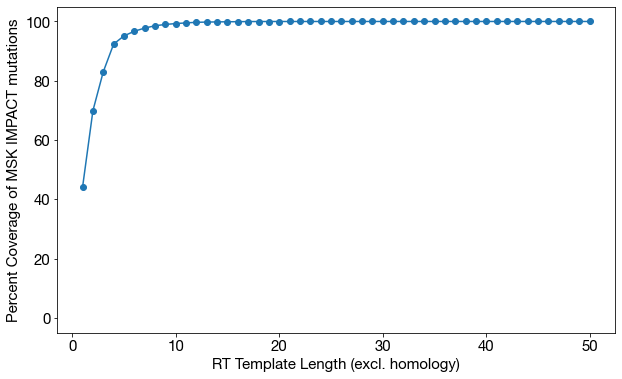

In [118]:
rt_template_length = np.linspace(1,50,50) #iterating through all RT template lengths from 1 to 50

plt.figure(figsize=(10,6))
plt.plot(rt_template_length,perc_coverage)
plt.scatter(rt_template_length,perc_coverage)
plt.ylim(-5,105)
plt.ylabel('Percent Coverage of MSK IMPACT mutations', fontsize=15)
plt.xlabel('RT Template Length (excl. homology)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.savefig('total_mutations.png', dpi=200)

## For further analysis, break down into subcategories of mutations (SNPS, INS, DELs, etc.)

## ALSO, need to exclude the indeces that fall outside of the domain. 

In [113]:
ONP = np.asarray(impact_data[impact_data['Variant_Type']=='ONP'].index)
SNP = np.asarray(impact_data[impact_data['Variant_Type']=='SNP'].index)
DNP = np.asarray(impact_data[impact_data['Variant_Type']=='DNP'].index)
TNP = np.asarray(impact_data[impact_data['Variant_Type']=='TNP'].index)
INS = np.asarray(impact_data[impact_data['Variant_Type']=='INS'].index)
DEL = np.asarray(impact_data[impact_data['Variant_Type']=='DEL'].index)

In [114]:
#not the prettiest, or most efficient way to do this, but it works
ONP_cover = []
SNP_cover = []
DNP_cover = []
TNP_cover = []
INS_cover = []
DEL_cover = []

ONP1 = []
SNP1 = []
DNP1 = []
TNP1 = []
INS1 = []
DEL1 = []

for i in cover_list: #iterating through different rt template lengths
    sumONP = 0
    sumSNP = 0
    sumDNP = 0
    sumTNP = 0
    sumINS = 0
    sumDEL = 0
    
    for k in ONP:
        sumONP+=i[k]
    
    for k in SNP:
        sumSNP += i[k]
        
    for k in DNP:
        sumDNP += i[k]
    
    for k in TNP:
        sumTNP += i[k]
        
    for k in INS:
        sumINS += i[k]
        
    for k in DEL:
        sumDEL += i[k]
        
        
    #del = counts[0]
    #dnp = counts[1]
    #ins = counts[2]
    #onp = counts[3]
    #snp = counts[4]    
    ONP_cover.append(sumONP/(len(ONP)))
    SNP_cover.append(sumSNP/(len(SNP)))
    DNP_cover.append(sumDNP/(len(DNP)))
    TNP_cover.append(sumTNP/(len(TNP)))
    INS_cover.append(sumINS/(len(INS)))
    DEL_cover.append(sumDEL/(len(DEL)))
    
        #onp = counts[3]
    #snp = counts[4]    
    ONP1.append(sumONP)
    SNP1.append(sumSNP)
    DNP1.append(sumDNP)
    TNP1.append(sumTNP)
    INS1.append(sumINS)
    DEL1.append(sumDEL)



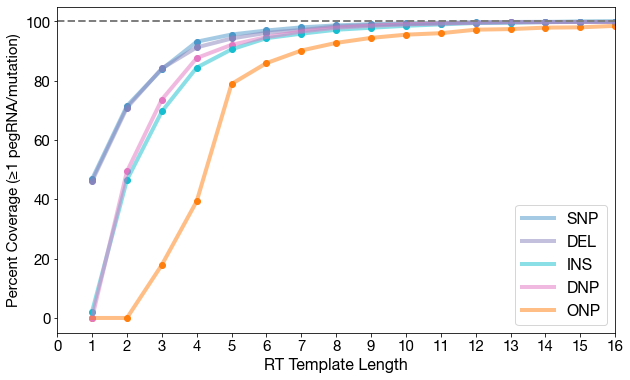

In [147]:
plt.figure(figsize=(10,6))

c_list = [plt.cm.Blues(0.6), 'tab:orange',plt.cm.Purples(0.6),'tab:pink', 'tab:cyan']

plt.plot(rt_template_length,np.asarray(SNP_cover)*100, label='SNP', color=plt.cm.Blues(0.6), linewidth=4, alpha=0.5)
#plt.plot(rt_template_length,TNP_cover, label='TNP' )
plt.plot(rt_template_length,np.asarray(DEL_cover)*100, label='DEL', color=plt.cm.Purples(0.6),linewidth=4, alpha=0.5)


plt.plot(rt_template_length,np.asarray(INS_cover)*100, label='INS' ,color='tab:cyan', linewidth=4, alpha=0.5)
plt.plot(rt_template_length,np.asarray(DNP_cover)*100, label='DNP', color='tab:pink', linewidth=4, alpha=0.5)


plt.plot(rt_template_length,np.asarray(ONP_cover)*100, label='ONP' , color='tab:orange', linewidth=4, alpha=0.5)
plt.plot([0,16], [100,100], linestyle='dashed', c='tab:grey', linewidth=2)


plt.scatter(rt_template_length,np.asarray(ONP_cover)*100, color='tab:orange')
plt.scatter(rt_template_length,np.asarray(SNP_cover)*100, color=plt.cm.Blues(0.6))
plt.scatter(rt_template_length,np.asarray(DNP_cover)*100, color='tab:pink')
#plt.plot(rt_template_length,TNP_cover, label='TNP' )
plt.scatter(rt_template_length,np.asarray(INS_cover)*100, color='tab:cyan')
plt.scatter(rt_template_length,np.asarray(DEL_cover)*100, color=plt.cm.Purples(0.6))

plt.legend(fontsize=16)

plt.ylim(-5,105)
plt.xlim(0,16)
plt.ylabel('Percent Coverage (≥1 pegRNA/mutation)', fontsize=15)
plt.xlabel('RT Template Length', fontsize=16)
plt.xticks(range(0,17),fontsize=15)
plt.yticks(fontsize=15)
#plt.grid(axis = 'x', linestyle='dashed')


#plt.savefig('RT_template_length_coverage_NOLINES.png', dpi=250)

In [165]:
group_size = [mut_types[0], mut_types[1], mut_types[2], sum(mut_types[3:])]

SNP    348145
DEL     49838
INS     17784
DNP      6042
ONP      1011
UNK         1
TNP         1
Name: Variant_Type, dtype: int64

In [189]:
np.round(100*np.asarray(subgroup_size)/sum(subgroup_size),1)

array([38.6, 43.8, 12.1,  5.5])

In [156]:
perc

array([82.3,  0.1,  0. , 17.6])

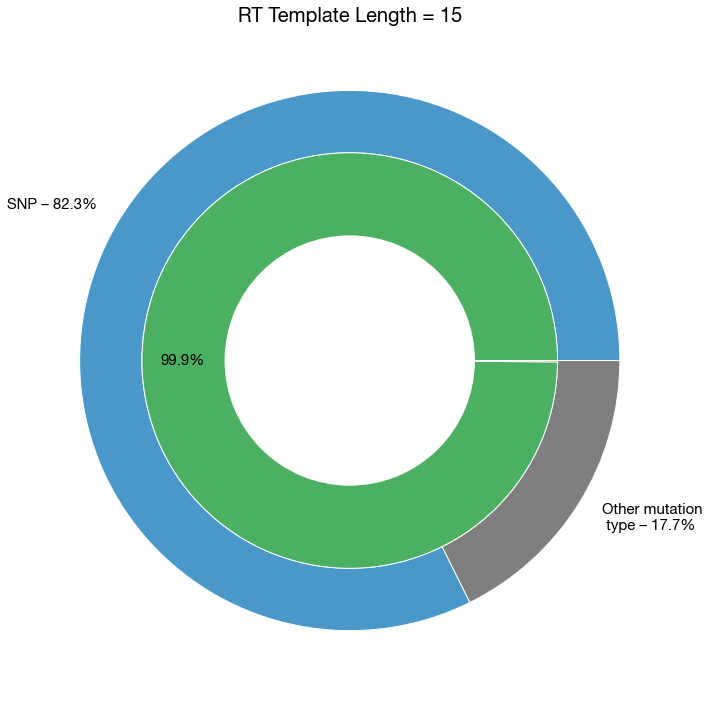

In [165]:
# Make data: I have 3 groups and 7 subgroups
group_names=['SNP – 82.3%', 'Other mutation \n type – 17.7%'] #
snp_unrecorded=unknown
group_size = [mut_types[0], sum(mut_types[0:])-mut_types[0]]

#subgroup_names=['editable', 'non-editable', 'non-editable','editable']

    
rt_len = 15-1
sum1 = ONP1[rt_len]+DNP1[rt_len]+INS1[rt_len]+ DEL1[rt_len] + TNP1[rt_len]

subgroup_size = [SNP1[rt_len]+sum1, (mut_types[0]-SNP1[rt_len])+ (sum(mut_types[1:])-sum1)]

perc= np.round(100*np.asarray(subgroup_size)/sum(subgroup_size),1)
subgroup_names=[str(perc[0])+'%','']
    
# Create colors
a, b, c, d=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens, plt.cm.Purples]
 
# First Ring (outside)
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=[a(0.6), 'tab:gray', c(0.6)], textprops={'fontsize': 15})
plt.setp( mypie, width=0.3, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, labels=subgroup_names, labeldistance=0.7, colors=[c(0.6), b(0.6), b(0.6),c(0.6), b(0.6)], textprops={'fontsize': 15})
plt.setp( mypie2, width=0.4, edgecolor='white')
plt.margins(0,0)

ax.set_title('RT Template Length = ' + str(rt_len+1), fontsize=20)
# show it
plt.tight_layout()
plt.show()

fig.savefig(str(rt_len+1) + 'corrected2.png', dpi=250)



(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 8 Text yticklabel objects>)

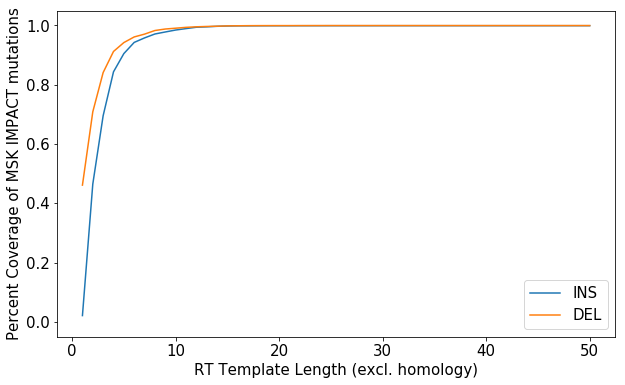

In [236]:
plt.figure(figsize=(10,6))
#plt.plot(rt_template_length,ONP_cover, label='ONP' )
#plt.plot(rt_template_length,SNP_cover, label='SNP' )
#plt.plot(rt_template_length,DNP_cover, label='DNP' )
#plt.plot(rt_template_length,TNP_cover, label='TNP' )
plt.plot(rt_template_length,INS_cover, label='INS' )
plt.plot(rt_template_length,DEL_cover, label='DEL' )
plt.legend(fontsize=15)

plt.ylim(-0.05,1.05)
plt.ylabel('Percent Coverage of MSK IMPACT mutations', fontsize=15)
plt.xlabel('RT Template Length (excl. homology)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)